<div style="text-align:center; color:#000000; font-size:32px; font-weight:bold;">Hiragana Images Classification using CNN</div>
<br>

<div style="text-align: center;"><img src="img/hiragana.jpg" alt="Image Description" width="600"/></div>

# Content

1. [Introduction](#introduction)
   - [Hiragana: A Fundamental Component of Japanese Writing](#hiragana)
   - [Objective](#objective)
2. [Import Libraries and Data](#import-libraries-and-data)
3. [Data Exploration](#data-exploration)
4. [Data Preprocessing](#data-preprocessing)
   - [Data split](#splitting)
   - [Pixel normalization](#normalization)
5. [Model Selection](#model-selection)
6. [Model Evaluation](#model-evaluation)
   - [Best model evaluation](#best-model)
   - [Classification results visualization](#results-visualization)
7. [Conclusion](#conclusion)
   - [Model choice](#model-choice)
   - [What's next](#whats-next)

# 1. Introduction <a id="introduction"></a>
### Hiragana: A Fundamental Component of Japanese Writing <a id="hiragana"></a>
Hiragana is a fundamental component of the Japanese writing system, consisting of characters representing syllables in the language. These curvy and rounded characters serve various roles, including native Japanese words, grammatical elements, and verb endings. Often learned first by beginners, they form an essential part of written Japanese alongside Katakana and Kanji characters.
### Objective <a id="objective"></a>
The aim of this project is to develop a CNN model capable of accurately classifying Hiragana images.

# 2. Import libraries and data <a id="import-libraries-and-data">

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import random
from tabulate import tabulate

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import load_model

In [2]:
filepath = './data/k49/'

train_images = np.load(filepath+'k49-train-imgs.npz')['arr_0']
train_labels = np.load(filepath+'k49-train-labels.npz')['arr_0']
test_images = np.load(filepath+'k49-test-imgs.npz')['arr_0']
test_labels = np.load(filepath+'k49-test-labels.npz')['arr_0']
classmap_df = pd.read_csv(filepath+'k49_classmap.csv')

# 2. Data Exploration <a id="data-exploration">

In [3]:
print("KMNIST train images shape:", train_images.shape)
print("KMNIST train labels shape:", train_labels.shape)
print("KMNIST test images shape:", test_images.shape)
print("KMNIST test labels shape:", test_labels.shape)

KMNIST train images shape: (232365, 28, 28)
KMNIST train labels shape: (232365,)
KMNIST test images shape: (38547, 28, 28)
KMNIST test labels shape: (38547,)


In [4]:
print("KMNIST character map shape:", classmap_df.shape)

KMNIST character map shape: (49, 3)


In [5]:
classmap_df.head()

,index,codepoint,char
0,0,U+3042,あ
1,1,U+3044,い
2,2,U+3046,う
3,3,U+3048,え
4,4,U+304A,お


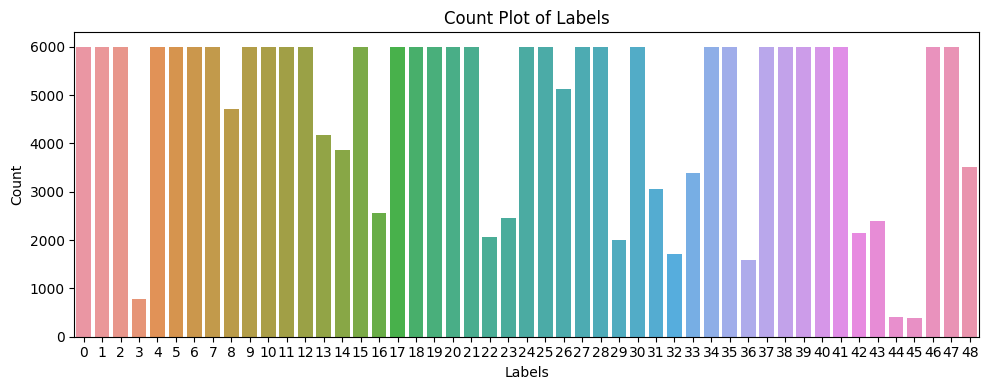

In [6]:
labels_series = pd.Series(train_labels)
plt.figure(figsize=(10, 4))
sns.countplot(x=labels_series)
plt.title('Count Plot of Labels')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.tight_layout()

The dataset reveals a notable imbalance among its classes, with the majority containing about 2000 observations or more, half of which have approximately 6000 instances each. In contrast, three classes exhibit fewer than 1000 observations.

In [7]:
### ChatGPT(3.5) assisted in crafting these functions
# Function to randomly select images based on their labels
def select_random_images_by_labels(images, labels, num_labels=5, num_images_per_label=5):
    # Get unique labels from the provided dataset
    unique_labels = np.unique(labels)
    
    # Choose a random subset of labels (up to num_labels)
    random_labels = random.sample(list(unique_labels), min(num_labels, len(unique_labels)))

    selected_images = []  # To store the selected images
    selected_labels = []  # To store the corresponding labels for the selected images
    for label in random_labels:
        indices = np.where(labels == label)[0]  # Get indices where label appears
        # Select a random subset of images for each label (up to num_images_per_label)
        random_indices = random.sample(list(indices), min(num_images_per_label, len(indices)))
        selected_images.extend(images[random_indices])  # Add selected images to the list
        selected_labels.extend([label] * len(random_indices))  # Store corresponding labels

    return np.array(selected_images), np.array(selected_labels)

# Function to plot randomly selected images with their labels as titles
def plot_random_images(images, labels, num_labels=5, num_images_per_label=5):
    # Select random images and their labels based on specified criteria
    selected_images, selected_labels = select_random_images_by_labels(images, labels, num_labels, num_images_per_label)

    num_rows = min(len(selected_images), num_images_per_label * num_labels)  # Calculate the number of rows based on available images
    num_cols = num_images_per_label

    # Create subplots to display images
    fig, axes = plt.subplots(num_rows // num_cols, num_cols, figsize=(10, 6))

    for i in range(num_rows):
        # Display each image and its corresponding label as title
        axes[i // num_cols, i % num_cols].imshow(selected_images[i], cmap='gray')  # Display image
        axes[i // num_cols, i % num_cols].set_title(f"Label: {selected_labels[i]}")  # Set label as title
        axes[i // num_cols, i % num_cols].axis('off')  # Hide axis

    plt.tight_layout()  # Adjust layout for better appearance
    plt.show()  # Display the plot

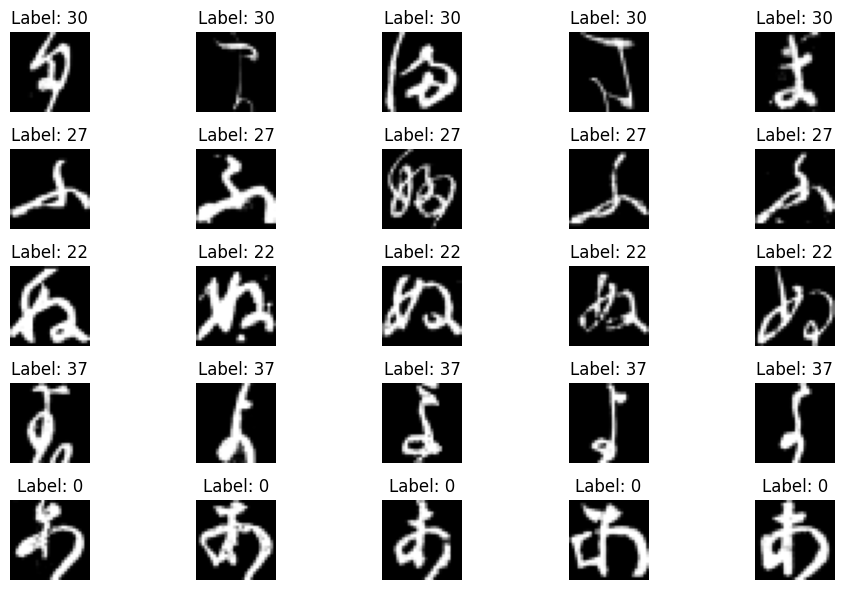

In [8]:
plot_random_images(train_images, train_labels, num_labels=5, num_images_per_label=5)

Randomly selected instances from various classes within the dataset, showcasing examples from different categories.

# 4. Data Preprocessing <a id="data-preprocessing">

In [9]:
# Reshape train_images to match the input shape for CNN
X = train_images.reshape(-1, 28, 28, 1)
y = train_labels

X_test = test_images.reshape(-1, 28, 28, 1)
y_test = test_labels

### Data split <a id="splitting">

In [10]:
# Split the data into training and testing sets (80% train, 20% test)
test_size = 0.2  
random_state = 42  
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

# Ensure the shapes of the sets are as expected
print("Train data shapes - X:", X_train.shape, " Y:", y_train.shape)
print("Validation data shapes - X:", X_val.shape, " Y:", y_val.shape)
print("Test data shapes - X:", X_test.shape, " Y:", y_test.shape)

Train data shapes - X: (185892, 28, 28, 1)  Y: (185892,)
Validation data shapes - X: (46473, 28, 28, 1)  Y: (46473,)
Test data shapes - X: (38547, 28, 28, 1)  Y: (38547,)


### Pixel normalization <a id="normalization">

In [11]:
# Convert the data type to float32 for precise calculations
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

# Normalize the pixel values to be between 0 and 1
X_train /= 255.0
X_val /= 255.0
X_test /= 255.0

# 5. Model Selection <a id="model-selection">

In [12]:
def plot_model_validation(history):
    plt.figure(figsize=(10, 4))
    
    # Loss Function Plot
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Loss')
    plt.plot(history['val_loss'], label='val_Loss')
    plt.title('Loss Function evolution during training')
    plt.legend()
    
    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Accuracy')
    plt.plot(history['val_accuracy'], label='val_Accuracy')
    plt.title('Accuracy evolution during training')
    plt.legend()
    plt.ylim((0,1))
    
    plt.tight_layout()
    plt.show()

In [13]:
IMG_ROWS, IMG_COLS = 28, 28
NUM_CLASSES = 49
BATCH_SIZE = 1024
EPOCHS = 100

In [14]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',
                 input_shape=(IMG_ROWS, IMG_COLS, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x=X_train, y=y_train, validation_data=(X_val,y_val), 
                    batch_size=BATCH_SIZE, epochs=EPOCHS, 
                    verbose=2)
model.save('models/model_1.h5')

Epoch 1/100
182/182 - 8s - loss: 1.8571 - accuracy: 0.5279 - val_loss: 0.9296 - val_accuracy: 0.7718 - 8s/epoch - 45ms/step
Epoch 2/100
182/182 - 4s - loss: 1.1111 - accuracy: 0.7062 - val_loss: 0.6449 - val_accuracy: 0.8358 - 4s/epoch - 23ms/step
Epoch 3/100
182/182 - 4s - loss: 0.9057 - accuracy: 0.7581 - val_loss: 0.5327 - val_accuracy: 0.8635 - 4s/epoch - 23ms/step
Epoch 4/100
182/182 - 4s - loss: 0.8069 - accuracy: 0.7828 - val_loss: 0.4795 - val_accuracy: 0.8758 - 4s/epoch - 23ms/step
Epoch 5/100
182/182 - 4s - loss: 0.7434 - accuracy: 0.7975 - val_loss: 0.4367 - val_accuracy: 0.8864 - 4s/epoch - 23ms/step
Epoch 6/100
182/182 - 4s - loss: 0.6952 - accuracy: 0.8097 - val_loss: 0.4049 - val_accuracy: 0.8941 - 4s/epoch - 23ms/step
Epoch 7/100
182/182 - 4s - loss: 0.6648 - accuracy: 0.8170 - val_loss: 0.3871 - val_accuracy: 0.8988 - 4s/epoch - 23ms/step
Epoch 8/100
182/182 - 4s - loss: 0.6385 - accuracy: 0.8239 - val_loss: 0.3690 - val_accuracy: 0.9028 - 4s/epoch - 23ms/step
Epoch 9/

Epoch 67/100
182/182 - 4s - loss: 0.3093 - accuracy: 0.9052 - val_loss: 0.2290 - val_accuracy: 0.9397 - 4s/epoch - 23ms/step
Epoch 68/100
182/182 - 4s - loss: 0.3067 - accuracy: 0.9051 - val_loss: 0.2272 - val_accuracy: 0.9402 - 4s/epoch - 23ms/step
Epoch 69/100
182/182 - 4s - loss: 0.3039 - accuracy: 0.9072 - val_loss: 0.2278 - val_accuracy: 0.9394 - 4s/epoch - 23ms/step
Epoch 70/100
182/182 - 4s - loss: 0.3042 - accuracy: 0.9062 - val_loss: 0.2248 - val_accuracy: 0.9408 - 4s/epoch - 23ms/step
Epoch 71/100
182/182 - 4s - loss: 0.3010 - accuracy: 0.9081 - val_loss: 0.2264 - val_accuracy: 0.9408 - 4s/epoch - 23ms/step
Epoch 72/100
182/182 - 4s - loss: 0.3027 - accuracy: 0.9077 - val_loss: 0.2255 - val_accuracy: 0.9406 - 4s/epoch - 23ms/step
Epoch 73/100
182/182 - 4s - loss: 0.2985 - accuracy: 0.9076 - val_loss: 0.2244 - val_accuracy: 0.9409 - 4s/epoch - 23ms/step
Epoch 74/100
182/182 - 4s - loss: 0.2946 - accuracy: 0.9090 - val_loss: 0.2256 - val_accuracy: 0.9404 - 4s/epoch - 23ms/step


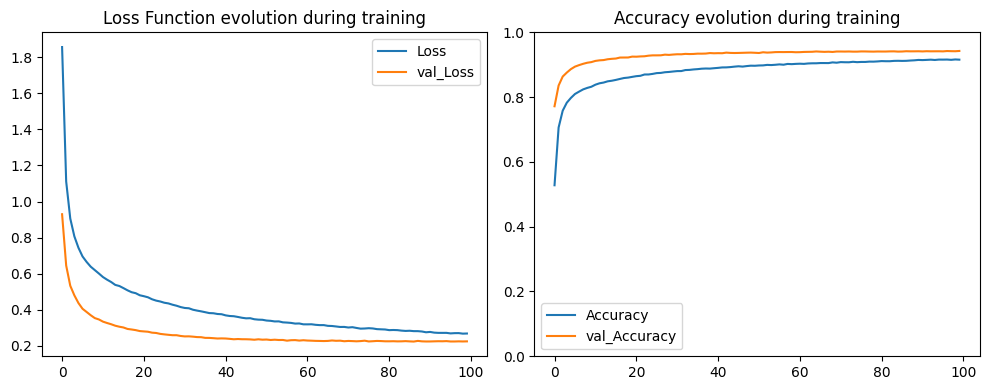

In [15]:
plot_model_validation(history.history)

In [16]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',
                 input_shape=(IMG_ROWS, IMG_COLS, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x=X_train, y=y_train, validation_data=(X_val,y_val), 
                    batch_size=BATCH_SIZE, epochs=EPOCHS, 
                    verbose=2)
model.save('models/model_2.h5')

Epoch 1/100
182/182 - 6s - loss: 1.9327 - accuracy: 0.5057 - val_loss: 0.7838 - val_accuracy: 0.7989 - 6s/epoch - 33ms/step
Epoch 2/100
182/182 - 5s - loss: 1.0021 - accuracy: 0.7321 - val_loss: 0.5107 - val_accuracy: 0.8684 - 5s/epoch - 27ms/step
Epoch 3/100
182/182 - 5s - loss: 0.7870 - accuracy: 0.7874 - val_loss: 0.4155 - val_accuracy: 0.8915 - 5s/epoch - 27ms/step
Epoch 4/100
182/182 - 5s - loss: 0.6811 - accuracy: 0.8146 - val_loss: 0.3588 - val_accuracy: 0.9048 - 5s/epoch - 27ms/step
Epoch 5/100
182/182 - 5s - loss: 0.6163 - accuracy: 0.8314 - val_loss: 0.3208 - val_accuracy: 0.9145 - 5s/epoch - 27ms/step
Epoch 6/100
182/182 - 5s - loss: 0.5665 - accuracy: 0.8439 - val_loss: 0.2934 - val_accuracy: 0.9212 - 5s/epoch - 27ms/step
Epoch 7/100
182/182 - 5s - loss: 0.5269 - accuracy: 0.8549 - val_loss: 0.2776 - val_accuracy: 0.9259 - 5s/epoch - 27ms/step
Epoch 8/100
182/182 - 5s - loss: 0.4958 - accuracy: 0.8617 - val_loss: 0.2572 - val_accuracy: 0.9310 - 5s/epoch - 27ms/step
Epoch 9/

Epoch 67/100
182/182 - 5s - loss: 0.2264 - accuracy: 0.9326 - val_loss: 0.1403 - val_accuracy: 0.9634 - 5s/epoch - 27ms/step
Epoch 68/100
182/182 - 5s - loss: 0.2221 - accuracy: 0.9338 - val_loss: 0.1425 - val_accuracy: 0.9628 - 5s/epoch - 27ms/step
Epoch 69/100
182/182 - 5s - loss: 0.2239 - accuracy: 0.9332 - val_loss: 0.1431 - val_accuracy: 0.9626 - 5s/epoch - 27ms/step
Epoch 70/100
182/182 - 5s - loss: 0.2229 - accuracy: 0.9336 - val_loss: 0.1413 - val_accuracy: 0.9632 - 5s/epoch - 27ms/step
Epoch 71/100
182/182 - 5s - loss: 0.2212 - accuracy: 0.9343 - val_loss: 0.1399 - val_accuracy: 0.9628 - 5s/epoch - 27ms/step
Epoch 72/100
182/182 - 5s - loss: 0.2190 - accuracy: 0.9345 - val_loss: 0.1400 - val_accuracy: 0.9634 - 5s/epoch - 27ms/step
Epoch 73/100
182/182 - 5s - loss: 0.2198 - accuracy: 0.9349 - val_loss: 0.1409 - val_accuracy: 0.9629 - 5s/epoch - 27ms/step
Epoch 74/100
182/182 - 5s - loss: 0.2161 - accuracy: 0.9348 - val_loss: 0.1406 - val_accuracy: 0.9635 - 5s/epoch - 27ms/step


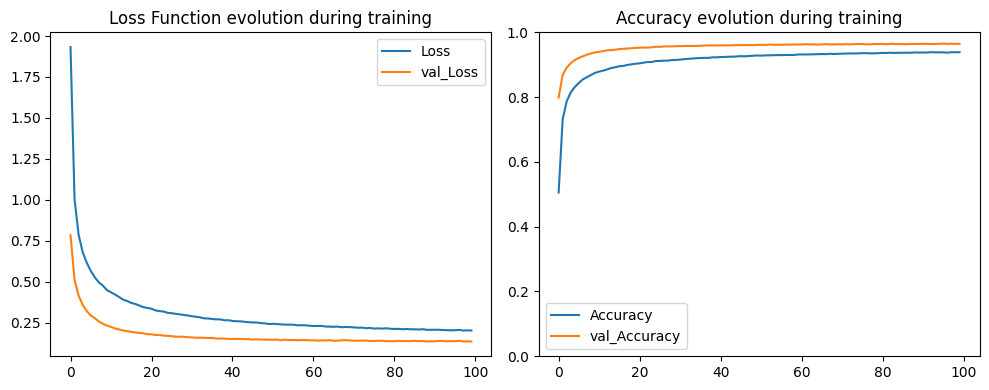

In [17]:
plot_model_validation(history.history)

# 6. Model Evaluation <a id="model-evaluation">

In [18]:
def print_classification_metrics(y_true, predicted_classes):
    # Generate a classification report
    report = classification_report(y_true, predicted_classes, output_dict=True)
    
    # Extract accuracy, macro average, and weighted average rounded to 2 decimals
    accuracy = round(report['accuracy'], 2)
    macro_avg = report['macro avg']
    weighted_avg = report['weighted avg']

    # Define the data
    data = {
        'Metric': ['Recall', 'Precision', 'F1-score', 'Support'],
        'Macro Average': [macro_avg['recall'], macro_avg['precision'], macro_avg['f1-score'], macro_avg['support']],
        'Weighted Average': [weighted_avg['recall'], weighted_avg['precision'], weighted_avg['f1-score'], weighted_avg['support']]
    }

    # Create a DataFrame
    df = pd.DataFrame(data)
    rounded_df = df.round(2)
    df.set_index('Metric', inplace=True)  

    # Display the DataFrame using tabulate
    print(tabulate(rounded_df, headers='keys', tablefmt='pretty'))
    print('Accuracy:', accuracy)

In [19]:
model = load_model('models/model_1.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 128)               692352    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

In [20]:
print('Evaluating on Validation data:')
predictions = model.predict(X_val)
predicted_classes = predictions.argmax(axis=1)
print_classification_metrics(y_val, predicted_classes)

Evaluating on Validation data:
1453/1453 [==============================] - 2s 2ms/step
+---+-----------+---------------+------------------+
|   |  Metric   | Macro Average | Weighted Average |
+---+-----------+---------------+------------------+
| 0 |  Recall   |     0.93      |       0.94       |
| 1 | Precision |     0.94      |       0.94       |
| 2 | F1-score  |     0.94      |       0.94       |
| 3 |  Support  |    46473.0    |     46473.0      |
+---+-----------+---------------+------------------+
Accuracy: 0.94


In [21]:
print('Evaluating on Test data:')
predictions = model.predict(X_test)
predicted_classes = predictions.argmax(axis=1)
print_classification_metrics(y_test, predicted_classes)

Evaluating on Test data:
1205/1205 [==============================] - 2s 2ms/step
+---+-----------+---------------+------------------+
|   |  Metric   | Macro Average | Weighted Average |
+---+-----------+---------------+------------------+
| 0 |  Recall   |     0.88      |       0.9        |
| 1 | Precision |     0.89      |       0.9        |
| 2 | F1-score  |     0.89      |       0.9        |
| 3 |  Support  |    38547.0    |     38547.0      |
+---+-----------+---------------+------------------+
Accuracy: 0.9


In [22]:
model = load_model('models/model_2.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 5, 5, 64)          0         
                                                                 
 flatten_1 (Flatten)         (None, 1600)             

In [23]:
print('Evaluating on Validation data:')
predictions = model.predict(X_val)
predicted_classes = predictions.argmax(axis=1)
print_classification_metrics(y_val, predicted_classes)

Evaluating on Validation data:
1453/1453 [==============================] - 3s 2ms/step
+---+-----------+---------------+------------------+
|   |  Metric   | Macro Average | Weighted Average |
+---+-----------+---------------+------------------+
| 0 |  Recall   |     0.96      |       0.96       |
| 1 | Precision |     0.96      |       0.96       |
| 2 | F1-score  |     0.96      |       0.96       |
| 3 |  Support  |    46473.0    |     46473.0      |
+---+-----------+---------------+------------------+
Accuracy: 0.96


In [24]:
print('Evaluating on Test data:')
predictions = model.predict(X_test)
predicted_classes = predictions.argmax(axis=1)
print_classification_metrics(y_test, predicted_classes)

Evaluating on Test data:
1205/1205 [==============================] - 2s 2ms/step
+---+-----------+---------------+------------------+
|   |  Metric   | Macro Average | Weighted Average |
+---+-----------+---------------+------------------+
| 0 |  Recall   |     0.93      |       0.94       |
| 1 | Precision |     0.93      |       0.94       |
| 2 | F1-score  |     0.93      |       0.94       |
| 3 |  Support  |    38547.0    |     38547.0      |
+---+-----------+---------------+------------------+
Accuracy: 0.94


We evaluated the performance of each model by examining their predictions on both the validation dataset (utilized during training) and the test dataset. The second model demonstrated better performance on both datasets compared to the first model.

### Best model evaluation <a id="best-model">

In [25]:
best_model = load_model('models/model_2.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 5, 5, 64)          0         
                                                                 
 flatten_1 (Flatten)         (None, 1600)             

In [26]:
predictions = model.predict(X_test)
predicted_classes = predictions.argmax(axis=1)

1205/1205 [==============================] - 2s 2ms/step


In [27]:
report = classification_report(y_test, predicted_classes)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1000
           1       0.97      0.97      0.97      1000
           2       0.94      0.97      0.95      1000
           3       0.88      0.91      0.89       126
           4       0.93      0.95      0.94      1000
           5       0.93      0.88      0.90      1000
           6       0.94      0.93      0.93      1000
           7       0.91      0.91      0.91      1000
           8       0.87      0.93      0.90       767
           9       0.92      0.92      0.92      1000
          10       0.97      0.95      0.96      1000
          11       0.96      0.92      0.94      1000
          12       0.92      0.94      0.93      1000
          13       0.93      0.84      0.88       678
          14       0.92      0.88      0.90       629
          15       0.95      0.95      0.95      1000
          16       0.93      0.98      0.95       418
          17       0.93    

In [28]:
# best_model.save('models/best_model.h5')

For most classes, the F1 score hovered around or exceeded 0.9 despite the inherent class imbalance. However, there was an exceptions in Class 44, which had a lower F1 score of 0.82, with over 2000 observations. This difference could be because some hiragana characters look very similar to others. This similarity might have caused the CNN to make mistakes by thinking one character is another.

Take, for instance:

- Class 44: Character 'ゐ' bears some resemblance to Class 23: 'ね'.
- Class 48: Character 'ゝ' resembles Class 17: 'つ'.

### Classification results Visualization <a id="results-visualization">

In [29]:
def print_pred_images(X, y, prediction, show_correct=True, num_images_to_plot=5):
    if show_correct:
        # Find correctly classified random indices
        indices = [i for i in range(len(prediction)) if prediction[i] == y[i]]
        indices_to_display = random.sample(indices, num_images_to_plot)
        cmap = 'Greens'
        title = 'Sample of Correctly Classified Images'
    else:
        # Find misclassified random indices
        indices = [i for i in range(len(prediction)) if prediction[i] != y[i]]
        indices_to_display = random.sample(indices, num_images_to_plot)
        cmap = 'Reds'
        title = 'Sample of Misclassified Images'
        
    fig, ax = plt.subplots(1, num_images_to_plot, figsize=(12, 3))

    for i, idx in enumerate(indices_to_display):
        # plot images
        ax[i].imshow(X[idx], cmap=cmap)
        ax[i].set_title(f"True: {y[idx]}, Predicted: {prediction[idx]}")
        ax[i].axis('off')
        

    fig.suptitle(title, fontsize=16)  
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
    plt.show()    

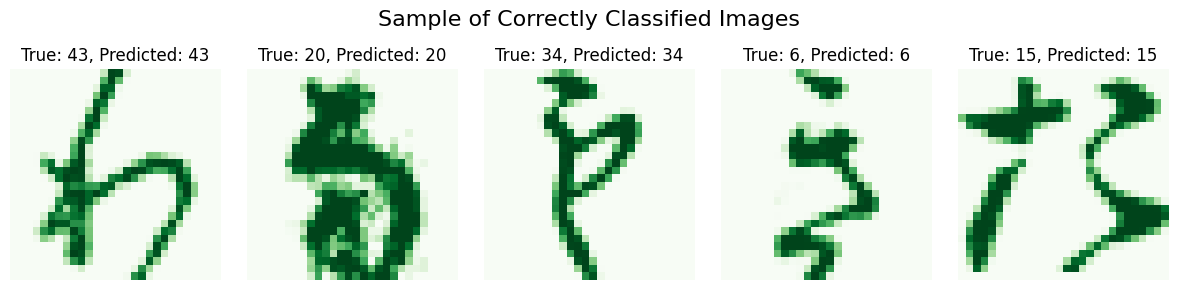

In [30]:
print_pred_images(X_test, y_test, predicted_classes) # correctly classified images

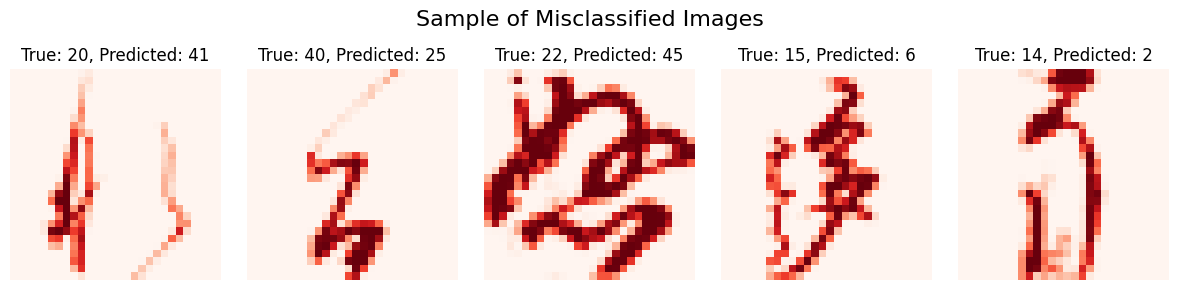

In [31]:
print_pred_images(X_test, y_test, predicted_classes, 0) # misclassified images

# 7. Conclusion <a id="conclusion">

### Model choice <a id="model-choice">
The CNN model, structured as shown in the "[Best model evaluation](#best-model)" section, attained impressive F1 scores overall. However, it encountered challenges with certain hiragana characters that bear visual resemblance to others in the images.

### What's next <a id="whats-next"></a>
- Possibly, reducing the impact of heavily populated classes by downsampling them could be beneficial.
- Considering more complex CNN models might be a potential strategy to address the issue of similar-looking hiragana characters.